# Intercomparison

**Author:** Adebowale Adebayo

**Last updated:** March 23, 2024

**Description:** Runs intercomparison and **area estimate** for Senegal 2022

## 1. Setup

In [ ]:
# !earthengine authenticate

In [ ]:
!git clone https://github.com/nasaharvest/crop-mask.git

In [2]:
%cd crop-mask/

/content/crop-mask


In [ ]:
!git checkout area-estimate-from-multi-land-cover

In [ ]:
!pip install cartopy -qq
!pip install rasterio -qq
!pip install dvc[gs] -qq

In [5]:
import ee
import geemap
import sys
import pandas as pd
import numpy as np

import geopandas as gpd
from pathlib import Path

ee.Authenticate()
ee.Initialize(project="bsos-geog-harvest1")

sys.path.append("../..")

from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, CLASS_COL, COUNTRY_COL, get_ensemble_area
from src.compare_covermaps import TEST_COUNTRIES, TEST_CODE

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


## 2. Read in evaluation set

In [6]:
country = "Senegal"

if country not in TEST_CODE:
    print(f"WARNING: {country} not found in TEST_CODE in src/compare_covermaps.py")
if country not in TEST_COUNTRIES:
    print(f"WARNING: {country} not found in TEST_COUNTRIES in src/compare_covermaps.py")
if country not in TEST_CODE or country not in TEST_COUNTRIES:
    print("Please update src/compare_covermaps.py and restart the notebook.")
else:
    country_code = TEST_CODE[country]
    # dataset_path = "../" + TEST_COUNTRIES[country]

In [7]:
# dataset_path = TEST_COUNTRIES[country]
dataset_path = 'data/datasets/Senegal_CEO_2022.csv'

In [ ]:
!dvc pull data/datasets

In [68]:
if not Path(dataset_path).exists():
    print(f"WARNING: Dataset: {dataset_path} not found, run `dvc pull data/datasets from root.")
else:
    df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
    df = df[(df["class_probability"] != 0.5)].copy()
    # use only test data because validation points used for harvest-dev map
    df = df[(df["subset"] == "validation") | (df["subset"] == "testing")].copy()
    df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
    df[COUNTRY_COL] = country

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
    gdf = filter_by_bounds(country_code=country_code, gdf=gdf)

## 3. Run intercomparison

In [69]:
gdf.head()

,lat,lon,class_probability,subset,binary,country,geometry
0,15.033306,-16.937735,0.000000,testing,0,Senegal,POINT (-16.93773 15.03331)
2,16.192133,-14.772795,0.000000,validation,0,Senegal,POINT (-14.77279 16.19213)
3,15.015340,-13.173794,0.000000,validation,0,Senegal,POINT (-13.17379 15.01534)
4,14.799744,-15.329750,0.000000,testing,0,Senegal,POINT (-15.32975 14.79974)
5,14.260755,-14.656014,0.333333,testing,0,Senegal,POINT (-14.65601 14.26076)


In [10]:
TARGETS = {k:v for k,v in TARGETS.items()}
for k, v in TARGETS.items():
    if country not in v.countries:
        continue
    if v.year is None:
        v.year = v.collection_years[v.countries.index(country)]

In [21]:
reference_year = 2022
TARGETS = {k: v for k, v in TARGETS.items() if v.year in range(reference_year - 2, reference_year + 2)} # Adjusted the year range to include more map products
# TARGETS = {k: v for k, v in TARGETS.items() if v.year in [reference_year - 2, reference_year, reference_year + 2]}

In [22]:
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=["lat", "lon"], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

[Senegal] sampling worldcover-v100...
[Senegal] sampling worldcover-v200...
[Senegal] sampling worldcereal-v100...


In [23]:
a_j = {}
for cropmap in TARGETS.values():
    if country not in cropmap.countries:
        continue
    print(f"[{country}] calculating pixel area for " + cropmap.title + "...")
    # a_j[cropmap.title] = cropmap.compute_map_area(country, export=True, dataset_name=cropmap.title).copy() # I already have the export map areas
    a_j[cropmap.title] = np.array([None,None])

[Senegal] calculating pixel area for worldcover-v100...
[Senegal] calculating pixel area for worldcover-v200...
[Senegal] calculating pixel area for worldcereal-v100...


In [24]:
# update a_j values with exported values
for cropmap in a_j.keys():
    try:
        area_df = pd.read_csv(f'./Crop_NonCrop_Area_Sum_Export-{country}-{cropmap}.csv')
    except:
        continue
    crop_area = int(area_df['crop_sum'][0])
    noncrop_area = int(area_df['noncrop_sum'][0])
    a_j[cropmap] = np.array([noncrop_area, crop_area])

In [25]:
# Change None to nan
a_j = {k: np.array([np.nan, np.nan]) if np.any(v == None) else v for k,v in a_j.items()}

In [26]:
from src.area_utils import compute_area_estimate, compute_area_error_matrix, compute_std_p_i
from sklearn.metrics import confusion_matrix

In [44]:
def compute_area_estimate(dataset, true, pred, a_j, resolution, year):
    cm = confusion_matrix(true, pred)
    total_px = a_j.sum()
    w_j = a_j / total_px

    am = compute_area_error_matrix(cm, w_j)
    a_i = am.sum(axis=1)
    std_a_i = compute_std_p_i(w_j, am, cm)
    err_a_i = 1.96 * std_a_i

    a_px = total_px * a_i
    err_px = err_a_i * total_px
    return pd.DataFrame(
        data={
            "dataset": dataset,
            "area_ha": a_px[1] * (resolution**2) / (100**2),
            "err_ha": err_px[1] * (resolution**2) / (100**2),
            "year": int(year),
        },
        index=[0],
    ).round(2)

In [57]:
comparisons = []
area_est = []
for cropmap in TARGETS.values():
    cropmap, resolution, year = cropmap.title, cropmap.resolution, cropmap.year
    if cropmap not in gdf.columns:
        continue
    temp = gdf[[CLASS_COL, cropmap]].dropna()
    area = compute_area_estimate(cropmap, temp[CLASS_COL], temp[cropmap], a_j[cropmap], resolution, year)
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap], a_j[cropmap], area_weighted=True)
    comparisons.append(comparison)
    area_est.append(area)

# # Add ensemble
# ensemble_maps = ["glad", "esri-lulc"] # Should be odd number

# print(f"Ensemble maps: {ensemble_maps}")
# ensemble = gdf[ensemble_maps].mode(axis='columns')
# a_j['ensemble-subset'] = get_ensemble_area(country, [TARGETS[name] for name in ensemble_maps])
# comparison = generate_report("ensemble-subset", country, gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], area_weighted=True)
# area = compute_area_estimate("ensemble-subset", gdf[CLASS_COL], ensemble, a_j['ensemble-subset'], 10)
# comparisons.append(comparison)
# area_est.append(area)

comparisons = pd.concat(comparisons).set_index(['dataset'])
area_est = pd.concat(area_est).set_index(['dataset'])

results = comparisons.merge(area_est, on='dataset')

In [ ]:
results.to_csv('results.csv')

In [58]:
results[['crop_f1','accuracy','std_acc','crop_recall_pa','std_crop_pa','crop_precision_ua','std_crop_ua','area_ha','err_ha', 'year']] # include User and producer's accuracy with their 95% CI

,crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,crop_precision_ua,std_crop_ua,area_ha,err_ha,year
dataset,,,,,,,,,,
worldcover-v100,0.65,0.89,0.01,0.70,0.03,0.62,0.04,2991154.22,343812.58,2020
worldcover-v200,0.67,0.90,0.01,0.73,0.03,0.63,0.04,2974111.70,334988.16,2021
worldcereal-v100,0.64,0.89,0.01,0.68,0.03,0.61,0.04,3013651.69,351020.07,2021


## 4. Visualize best available map

In [59]:
results.dropna(inplace=True)

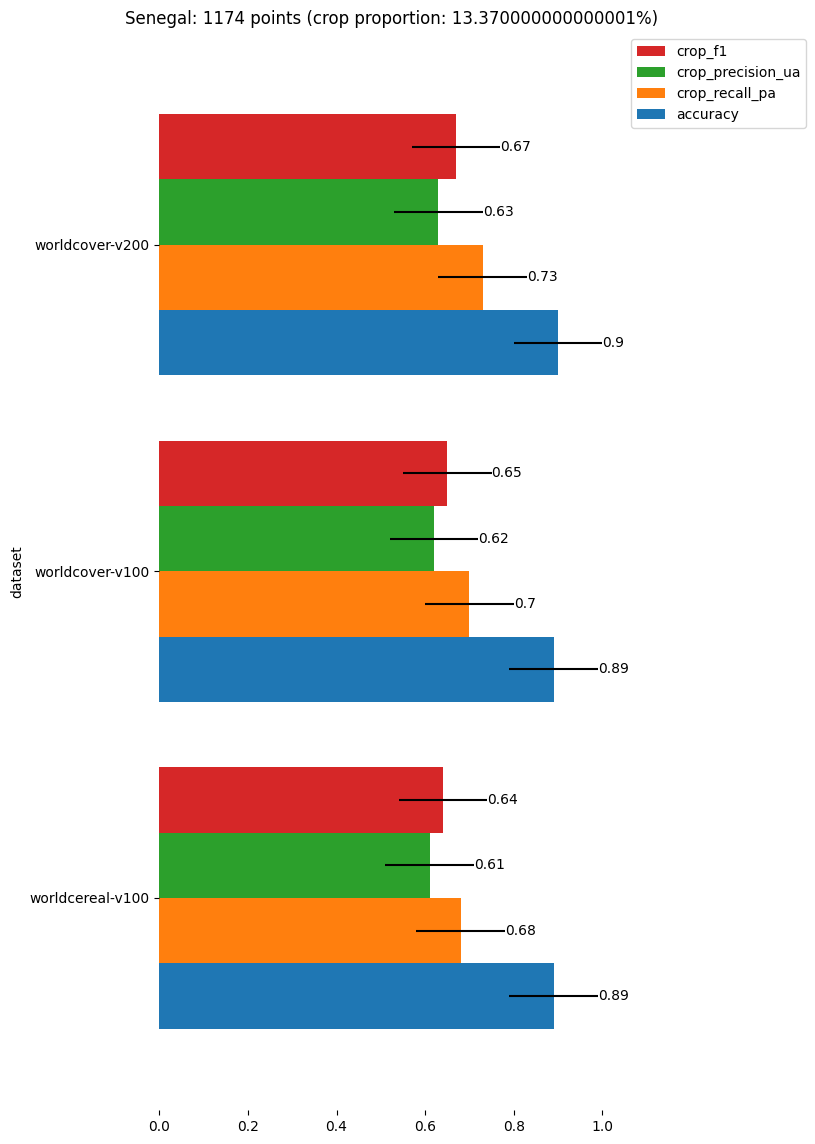

In [31]:
crop_proportion = round(gdf[CLASS_COL].value_counts(normalize=True)[1], 4) * 100
ax = results.sort_values("crop_f1").plot(
    y=["accuracy", "crop_recall_pa", "crop_precision_ua", "crop_f1"],
    xerr="std_crop_f1",
    kind="barh",
    figsize=(6, 14),
    width=0.8,
    title=f"{country}: {len(gdf)} points (crop proportion: {crop_proportion}%)",
);

for c in ax.containers[1::2]:
    ax.bar_label(c)

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

ax.legend(bbox_to_anchor=(1, 1), reverse=True);

In [60]:
fao_stat = pd.read_csv("./data/ref_samples_area/FAOSTAT_data_en_3-13-2024.csv")
fao_stat = fao_stat[fao_stat['Area'] == country]
fao_stat = fao_stat[fao_stat['Year'] == 2021]['Value'] * 1000 # Using 2021, no data for 2022
results = pd.concat([results, pd.DataFrame({'dataset':['FAOSTAT'], 'area_ha':fao_stat, 'err_ha':0, 'year':2021}).set_index(['dataset'])])

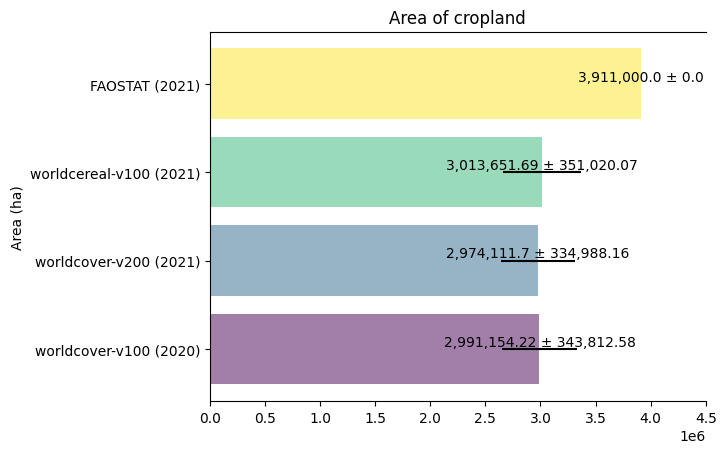

In [66]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

n = len(results)
colors = plt.cm.viridis(np.linspace(0, 1, n))

ax.barh(
    results.index,
    results["area_ha"],
    xerr=results["err_ha"],
    align="center",
    alpha=0.5,
    ecolor="black",
    color= colors
)

ax.set_xticks(ax.get_xticks()); ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f"{dataset} ({int(results.year[dataset])})" for dataset in results.index])

for i, (value, err) in enumerate(zip(results["area_ha"], results["err_ha"])):
    ax.text(value, i, f"{value:,} ± {err:,}", ha="center", va="bottom")
ax.set_ylabel("Area (ha)")
ax.set_title("Area of cropland")
ax.spines["right"].set_visible(False)
plt.show()